In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from time import time


class GridWorld:
    def __init__(self, filename, reward, random_rate, time_limit=1000):
        file = open(filename)
        self.map = np.array(
            [list(map(float, s.strip().split(","))) for s in file.readlines()]
        )
        file.close()
        self.num_rows = self.map.shape[0]
        self.num_cols = self.map.shape[1]
        self.num_states = self.num_rows * self.num_cols
        self.num_actions = 4
        self.reward = reward
        self.random_rate = random_rate
        self.time_limit = time_limit
        self.reward_function = self.get_reward_function()
        self.transition_model = self.get_transition_model()

    def get_state_from_pos(self, pos):
        return pos[0] * self.num_cols + pos[1]

    def get_pos_from_state(self, state):
        return state // self.num_cols, state % self.num_cols

    def get_reward_function(self):
        reward_table = np.zeros(self.num_states)
        for r in range(self.num_rows):
            for c in range(self.num_cols):
                s = self.get_state_from_pos((r, c))
                reward_table[s] = self.reward[self.map[r, c]]
        return reward_table

    def get_transition_model(self):
        ####READ THE ALGORITHM CAREFULLY AND WRITE THE CODE HERE
        '''Step 1: Initialize transition_model as a zero matrix of shape (num_states, num_actions, num_states).

        Step 2: Iterate over each grid cell (r, c), retrieve state s = get_state_from_pos((r, c)), and initialize neighbor_s.

        Step 3: If map[r, c] == 0 (traversable cell), determine new position (new_r, new_c) based on the action while handling boundaries and obstacles, then store the corresponding state s_prime in neighbor_s.

        Step 4: If the cell is non-traversable, set neighbor_s[a] = s for all actions to ensure no movement.

        Step 5: Update transition_model by assigning 1 - random_rate to neighbor_s[a] (intended move) and random_rate / 2 to left and right neighboring transitions (random drift).

        Step 6: Return the transition_model representing state-action transitions under uncertainty.
    '''

        # Initialize transition model as 3D array (state, action, next_state)
        transition_model = np.zeros((self.num_states, self.num_actions, self.num_states))

        # Define action directions: up, right, down, left
        actions = [(-1, 0), (0, 1), (1, 0), (0, -1)]

        # Iterate through each cell in the grid
        for r in range(self.num_rows):
            for c in range(self.num_cols):
                # Get current state
                s = self.get_state_from_pos((r, c))

                # Initialize neighbors for each action
                neighbor_s = np.zeros(self.num_actions, dtype=int)

                # If the cell is traversable
                if self.map[r, c] == 0 or self.map[r, c] == 1 or self.map[r, c] == 2:
                    # For each action, determine the next state
                    for a in range(self.num_actions):
                        # Calculate new position based on action
                        new_r = r + actions[a][0]
                        new_c = c + actions[a][1]

                        # Check if new position is valid (within bounds and not an obstacle)
                        if (0 <= new_r < self.num_rows and
                            0 <= new_c < self.num_cols and
                            self.map[new_r, new_c] != 3):
                            # Get the next state
                            neighbor_s[a] = self.get_state_from_pos((new_r, new_c))
                        else:
                            # If move is invalid, stay in current state
                            neighbor_s[a] = s
                else:
                    # For non-traversable cells, all actions lead to staying in the same state
                    for a in range(self.num_actions):
                        neighbor_s[a] = s

                # Set transition probabilities
                for a in range(self.num_actions):
                    # Main action (intended move)
                    transition_model[s, a, neighbor_s[a]] += 1 - self.random_rate

                    # Random drifts to left and right (circular reference to handle edge cases)
                    left_action = (a - 1) % self.num_actions
                    right_action = (a + 1) % self.num_actions

                    # Add probability for random drift
                    transition_model[s, a, neighbor_s[left_action]] += self.random_rate / 2
                    transition_model[s, a, neighbor_s[right_action]] += self.random_rate / 2

        return transition_model
    def generate_random_policy(self):
        return np.random.randint(self.num_actions, size=self.num_states)

    def execute_policy(self, policy, start_pos):
        ####READ THE ALGORITHM CAREFULLY AND WRITE THE CODE HERE
        '''Step 1: Initialize s as the starting state from start_pos using get_state_from_pos(start_pos).
        Step 2: Retrieve initial reward r from reward_function[s] and set total_reward to r.
        Step 3: Record the start_time in milliseconds and initialize overtime as False.
        Step 4: While the reward r is not equal to terminal states (reward[1] or reward[2]):
        Step 4.1: Choose next state s based on the policy using the transition probabilities transition_model[s, policy[s]].
        Step 4.2: Update the reward r from reward_function[s] and add r to total_reward.
        Step 4.3: Calculate elapsed time as cur_time and check if it exceeds time_limit; if exceeded, set overtime to True and break the loop.
        Step 5: If overtime is True, return negative infinity (-inf), indicating failure due to time limit.
        Step 6: Else, return total_reward, representing the cumulative reward obtained.'''
        # Get initial state from start position
        s = self.get_state_from_pos(start_pos)
        # Get initial reward
        r = self.reward_function[s]
        total_reward = r
        # Record start time
        start_time = int(round(time() * 1000))
        overtime = False
        # Continue until reaching a terminal state (green or red cell)
        while r != self.reward[1] and r != self.reward[2]:
            # Choose next state based on policy and transition probabilities
            probs = self.transition_model[s, policy[s]]
            s = np.random.choice(self.num_states, p=probs)
            # Get reward for new state and add to total
            r = self.reward_function[s]
            total_reward += r
            # Check if time limit exceeded
            cur_time = int(round(time() * 1000)) - start_time
            if cur_time > self.time_limit:
                overtime = True
                break
        # If overtime, return negative infinity (failure)
        if overtime:
            return float('-inf')
        # Otherwise return total reward
        return total_reward

    def random_start_policy(self, policy, start_pos, n=100, plot=True):
        start_time = int(round(time() * 1000))
        overtime = False
        scores = np.zeros(n)
        i = 0
        while i < n:
            temp = self.execute_policy(policy=policy, start_pos=start_pos)
            print(f'i = {i} Random start result: {temp}')
            if temp > float('-inf'):
                scores[i] = temp
                i += 1
            cur_time = int(round(time() * 1000)) - start_time
            if cur_time > n * self.time_limit:
                overtime = True
                break

        print(f'max = {np.max(scores)}')
        print(f'min = {np.min(scores)}')
        print(f'mean = {np.mean(scores)}')
        print(f'std = {np.std(scores)}')

        if overtime is False and plot is True:
            bins = 100
            fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)
            ax.set_xlabel('Total rewards in a single game')
            ax.set_ylabel('Frequency')
            ax.hist(scores, bins=bins, color='#1f77b4', edgecolor='black')
            plt.show()

        if overtime is True:
            print('Overtime!')
            return None
        else:
            return np.max(scores), np.min(scores), np.mean(scores)

    def blackbox_move(self, s, a):
        temp = self.transition_model[s, a]
        s_prime = np.random.choice(self.num_states, p=temp)
        r = self.reward_function[s_prime]
        return s_prime, r

    def plot_map(self, fig_size=(8, 6)):
        unit = min(fig_size[1] // self.num_rows, fig_size[0] // self.num_cols)
        unit = max(1, unit)
        fig, ax = plt.subplots(1, 1, figsize=fig_size)
        ax.axis('off')
        for i in range(self.num_cols + 1):
            if i == 0 or i == self.num_cols:
                ax.plot([i * unit, i * unit], [0, self.num_rows * unit],
                        color='black')
            else:
                ax.plot([i * unit, i * unit], [0, self.num_rows * unit],
                        alpha=0.7, color='grey', linestyle='dashed')
        for i in range(self.num_rows + 1):
            if i == 0 or i == self.num_rows:
                ax.plot([0, self.num_cols * unit], [i * unit, i * unit],
                        color='black')
            else:
                ax.plot([0, self.num_cols * unit], [i * unit, i * unit],
                        alpha=0.7, color='grey', linestyle='dashed')

        for i in range(self.num_rows):
            for j in range(self.num_cols):
                y = (self.num_rows - 1 - i) * unit
                x = j * unit
                if self.map[i, j] == 3:
                    rect = patches.Rectangle((x, y), unit, unit, edgecolor='none', facecolor='black',
                                             alpha=0.6)
                    ax.add_patch(rect)
                elif self.map[i, j] == 2:
                    rect = patches.Rectangle((x, y), unit, unit, edgecolor='none', facecolor='red',
                                             alpha=0.6)
                    ax.add_patch(rect)
                elif self.map[i, j] == 1:
                    rect = patches.Rectangle((x, y), unit, unit, edgecolor='none', facecolor='green',
                                             alpha=0.6)
                    ax.add_patch(rect)

        plt.tight_layout()
        plt.show()

    def plot_policy(self, policy, fig_size=(8, 6)):
        unit = min(fig_size[1] // self.num_rows, fig_size[0] // self.num_cols)
        unit = max(1, unit)
        fig, ax = plt.subplots(1, 1, figsize=fig_size)
        ax.axis('off')
        for i in range(self.num_cols + 1):
            if i == 0 or i == self.num_cols:
                ax.plot([i * unit, i * unit], [0, self.num_rows * unit],
                        color='black')
            else:
                ax.plot([i * unit, i * unit], [0, self.num_rows * unit],
                        alpha=0.7, color='grey', linestyle='dashed')
        for i in range(self.num_rows + 1):
            if i == 0 or i == self.num_rows:
                ax.plot([0, self.num_cols * unit], [i * unit, i * unit],
                        color='black')
            else:
                ax.plot([0, self.num_cols * unit], [i * unit, i * unit],
                        alpha=0.7, color='grey', linestyle='dashed')

        for i in range(self.num_rows):
            for j in range(self.num_cols):
                y = (self.num_rows - 1 - i) * unit
                x = j * unit
                if self.map[i, j] == 3:
                    rect = patches.Rectangle((x, y), unit, unit, edgecolor='none', facecolor='black',
                                             alpha=0.6)
                    ax.add_patch(rect)
                elif self.map[i, j] == 2:
                    rect = patches.Rectangle((x, y), unit, unit, edgecolor='none', facecolor='red',
                                             alpha=0.6)
                    ax.add_patch(rect)
                elif self.map[i, j] == 1:
                    rect = patches.Rectangle((x, y), unit, unit, edgecolor='none', facecolor='green',
                                             alpha=0.6)
                    ax.add_patch(rect)
                s = self.get_state_from_pos((i, j))
                if self.map[i, j] == 0:
                    a = policy[s]
                    symbol = ['^', '>', 'v', '<']
                    ax.plot([x + 0.5 * unit], [y + 0.5 * unit], marker=symbol[a],
                            linestyle='none', markersize=max(fig_size)*unit, color='#1f77b4')

        plt.tight_layout()
        plt.show()

    def visualize_value_policy(self, policy, values, fig_size=(8, 6)):
        unit = min(fig_size[1] // self.num_rows, fig_size[0] // self.num_cols)
        unit = max(1, unit)
        fig, ax = plt.subplots(1, 1, figsize=fig_size)
        ax.axis('off')

        for i in range(self.num_cols + 1):
            if i == 0 or i == self.num_cols:
                ax.plot([i * unit, i * unit], [0, self.num_rows * unit],
                        color='black')
            else:
                ax.plot([i * unit, i * unit], [0, self.num_rows * unit],
                        alpha=0.7, color='grey', linestyle='dashed')
        for i in range(self.num_rows + 1):
            if i == 0 or i == self.num_rows:
                ax.plot([0, self.num_cols * unit], [i * unit, i * unit],
                        color='black')
            else:
                ax.plot([0, self.num_cols * unit], [i * unit, i * unit],
                        alpha=0.7, color='grey', linestyle='dashed')

        for i in range(self.num_rows):
            for j in range(self.num_cols):
                y = (self.num_rows - 1 - i) * unit
                x = j * unit
                s = self.get_state_from_pos((i, j))
                if self.map[i, j] == 3:
                    rect = patches.Rectangle((x, y), unit, unit, edgecolor='none', facecolor='black',
                                             alpha=0.6)
                    ax.add_patch(rect)
                elif self.map[i, j] == 2:
                    rect = patches.Rectangle((x, y), unit, unit, edgecolor='none', facecolor='red',
                                             alpha=0.6)
                    ax.add_patch(rect)
                elif self.map[i, j] == 1:
                    rect = patches.Rectangle((x, y), unit, unit, edgecolor='none', facecolor='green',
                                             alpha=0.6)
                    ax.add_patch(rect)
                if self.map[i, j] != 3:
                    ax.text(x + 0.5 * unit, y + 0.5 * unit, f'{values[s]:.4f}',
                            horizontalalignment='center', verticalalignment='center',
                            fontsize=max(fig_size)*unit*0.6)
                if policy is not None:
                    if self.map[i, j] == 0:
                        a = policy[s]
                        symbol = ['^', '>', 'v', '<']
                        ax.plot([x + 0.5 * unit], [y + 0.5 * unit], marker=symbol[a], alpha=0.4,
                                linestyle='none', markersize=max(fig_size)*unit, color='#1f77b4')

        plt.tight_layout()
        plt.show()

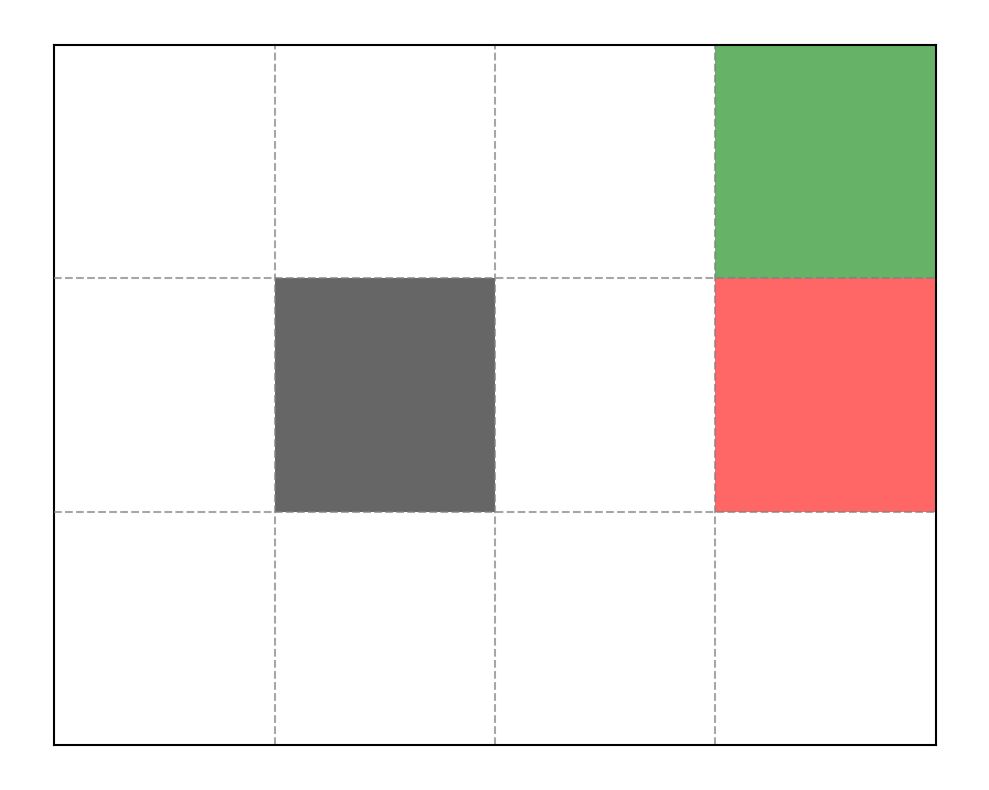

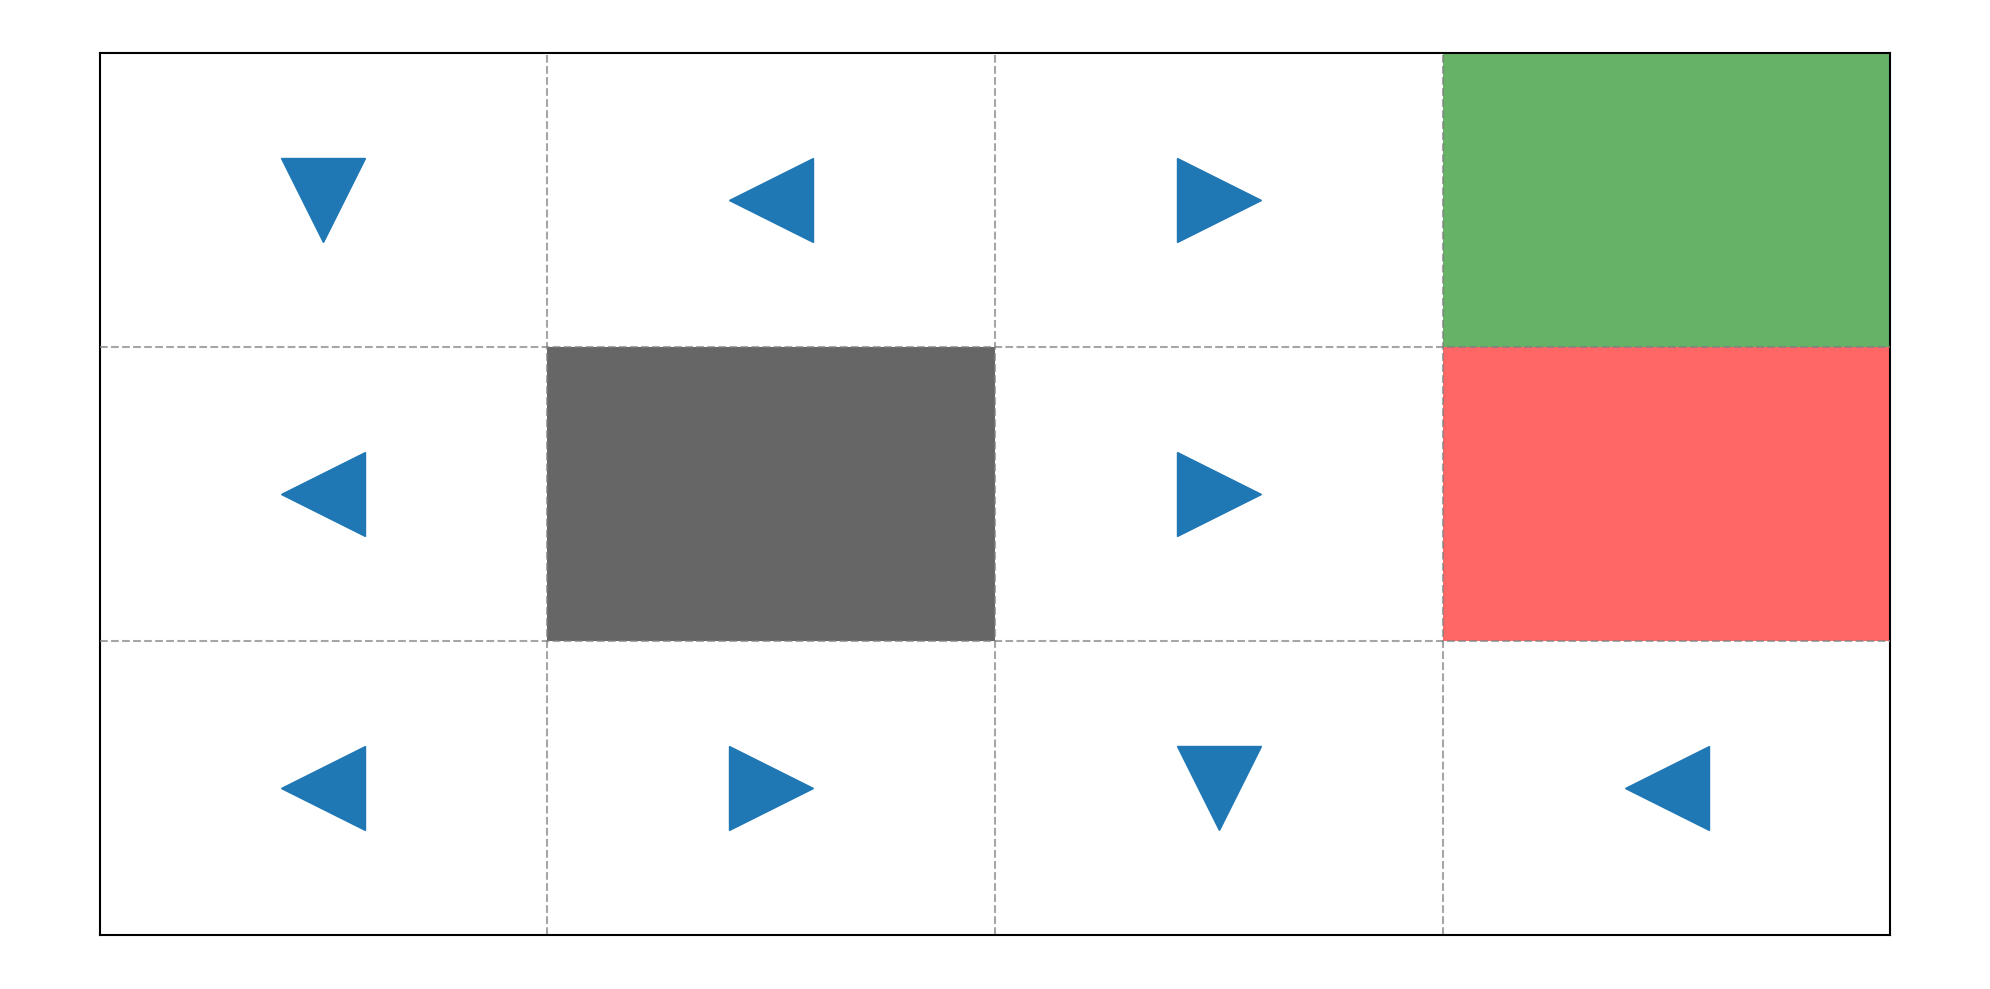

/tmp/ipykernel_133604/3872437769.py:321: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


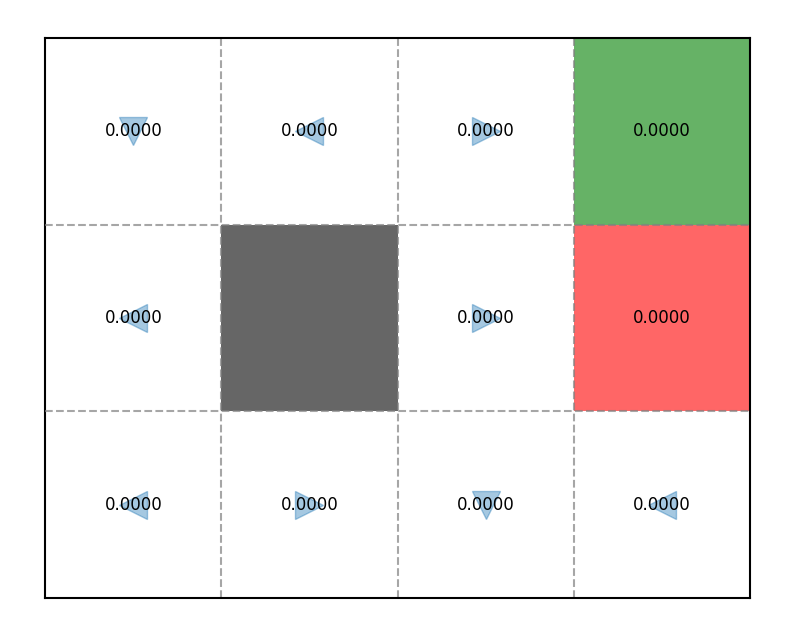

reward function =
State s = 0, Reward R(0) = -0.04
State s = 1, Reward R(1) = -0.04
State s = 2, Reward R(2) = -0.04
State s = 3, Reward R(3) = 1.0
State s = 4, Reward R(4) = -0.04
State s = 5, Reward R(5) = nan
State s = 6, Reward R(6) = -0.04
State s = 7, Reward R(7) = -1.0
State s = 8, Reward R(8) = -0.04
State s = 9, Reward R(9) = -0.04
State s = 10, Reward R(10) = -0.04
State s = 11, Reward R(11) = -0.04
transition model =
--------------------------------------
s = 0, a = 0, s' = 0, p = 0.9
s = 0, a = 0, s' = 1, p = 0.1
s = 0, a = 0, s' = 2, p = 0.0
s = 0, a = 0, s' = 3, p = 0.0
s = 0, a = 0, s' = 4, p = 0.0
s = 0, a = 0, s' = 5, p = 0.0
s = 0, a = 0, s' = 6, p = 0.0
s = 0, a = 0, s' = 7, p = 0.0
s = 0, a = 0, s' = 8, p = 0.0
s = 0, a = 0, s' = 9, p = 0.0
s = 0, a = 0, s' = 10, p = 0.0
s = 0, a = 0, s' = 11, p = 0.0
--------------------------------------
s = 0, a = 1, s' = 0, p = 0.1
s = 0, a = 1, s' = 1, p = 0.8
s = 0, a = 1, s' = 2, p = 0.0
s = 0, a = 1, s' = 3, p = 0.0
s = 0, a

In [5]:
problem = GridWorld('world00.csv', reward={0: -0.04, 1: 1.0, 2: -1.0, 3: np.nan}, random_rate=0.2)
# problem = GridWorld('data/world02.csv', reward={0: -0.04, 1: 10.0, 2: -10.0, 3: np.NaN}, random_rate=0.2)

problem.plot_map(fig_size=(10, 8))

init_policy = problem.generate_random_policy()
problem.plot_policy(init_policy, fig_size=(20, 10))
problem.visualize_value_policy(init_policy, np.zeros(problem.num_states), fig_size=(10, 8))

reward_function = problem.reward_function
print(f'reward function =')
for s in range(len(reward_function)):
    print(f'State s = {s}, Reward R({s}) = {reward_function[s]}')

transition_model = problem.transition_model
print(f'transition model =')
for s in range(transition_model.shape[0]):
    print('======================================')
    for a in range(transition_model.shape[1]):
        print('--------------------------------------')
        for s_prime in range(transition_model.shape[2]):
            print(f's = {s}, a = {a}, s\' = {s_prime}, p = {transition_model[s, a, s_prime]}')